Script to calculate the in-plane IFC of a twisted bilayer of any pair of materials (MoO3 as example). Based on thin layer approximation.

# Open the packages for the script

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define some useful functions for the code
cos = np.cos
sin = np.sin
exp = np.exp
pi = np.pi

## Define the function of the permittivity of MoO3
Parameters from paper: https://onlinelibrary.wiley.com/doi/abs/10.1002/adma.201908176

In [3]:
def eps_harm_Osc(w, wT, wL, gamma):
    eps_h = (w*w-wL**2+1j*gamma*w)/(w*w-wT**2+1j*gamma*w)
    return eps_h

In [4]:
def eps_MoO3(w, axis):
    if(axis=='[100]'): # x-axis of MoO3
        epsinf = 6.09
        gamma = np.array([[73, 11.9, 2.1]])
        wTO = np.array([[507, 822.7, 998.8]])
        wLO = np.array([[534, 978.8, 999.5]])

    if(axis=='[001]'): # z-axis of MoO3
        epsinf = 6.38
        gamma = np.array([[17.9]])
        wTO = np.array([[544.9]])
        wLO = np.array([[855.8]])

    if(axis=='[010]'): # y-axis of MoO3
        epsinf = 4.4
        gamma = np.array([[0.7]])
        wTO = np.array([[963]])
        wLO = np.array([[1006.6]])

    eps = np.ones(np.shape(w)[0],)
    for i in range(np.shape(wTO)[1]):
        eps = eps*eps_harm_Osc(w,wTO[0,i],wLO[0,i],gamma[0,i])

    eps = epsinf*eps

    return eps

# Calculate the in-plane IFC
Formula from the article: https://pubs.acs.org/doi/abs/10.1021/acs.nanolett.0c01673


In [18]:
# Inputs:
nw = 120 # Discretization in frequency
w = np.linspace(840,960,nw) # Frequency in cm^-1
e3 = 1 # Permittivity of the substrate
e2 = 1 # Permittivity of the interlayer
e1 = 1 # Permittivity of the superstrate
t1 = 0.2 # Thickness of the lower layer, in um
t2 = 0.2 # Thickness of the upper layer, in um
theta = np.array([[pi/3,pi/6]]) # Twist angle between layers
psi = 0 # Direction in-plane to calculate the dispersion. 0 is chosen to be the x-axis
maxK = 50 # Max momentum to plot
nK = 100 # Discretization in momentum
# Script:

# Separation between layers
h = (t1+t2)/2

# In-plane momentum
k = np.linspace(10e-14,maxK,nK) # In k=0 there is a divergence
kx = k*cos(psi)
ky = k*sin(psi)

# Permittivity of the material
epsx = eps_MoO3(w, '[100]')
epsy = eps_MoO3(w, '[001]')

# Initialize Z to plot

Z = np.zeros((nw,nK,np.shape(theta)[1]))+0j

# Loop in all possible angles

for i in range(nw):

    # Momentum and wavelength
    lam = 10**4/w[i]
    k0 = 2*pi/lam

    # Diagonal conductivity of upper and lower layers
    alf1xx = pi*t1/(1j*lam)*epsx[i]
    alf1yy = pi*t1/(1j*lam)*epsy[i]
    alf2x = pi*t2/(1j*lam)*epsx[i]
    alf2y = pi*t2/(1j*lam)*epsy[i]

    for l in range(np.shape(theta)[1]):

        # Non-diagonal upper matrix conductivity
        alf2xx = alf2x*cos(theta[0,l])**2+alf2y*sin(theta[0,l])**2
        alf2yy = alf2x*sin(theta[0,l])**2+alf2y*cos(theta[0,l])**2
        alf2xy = sin(theta[0,l])*cos(theta[0,l])*(alf2y-alf2x)

        # Loop in in-plane momentum
        for j in range(nK):

            # Calculate kt and kz
            kt = np.array([[kx[j]+0j,ky[j]+0j]])
            normkt = np.vdot(kt,kt)
            k1z=np.sqrt(e1*k0**2-normkt)
            k2z=np.sqrt(e2*k0**2-normkt)
            k2z1=np.sqrt(e2-normkt/(w**2)*137**2)
            k3z=np.sqrt(e3*k0**2-normkt)

            # Matricial elements <beta|alpha|beta'>

            sa1s = (ky[j]**2*alf1xx+kx[j]**2*alf1yy)/normkt
            sa1p = (ky[j]*kx[j]*(alf1yy-alf1xx))/normkt
            pa1p = (ky[j]**2*alf1yy+kx[j]**2*alf1xx)/normkt
            pa1s = sa1p
            sa2s = (ky[j]**2*alf2xx+kx[j]**2*alf2yy-2*alf2xy*kx[j]*ky[j])/normkt
            sa2p = (ky[j]*kx[j]*(alf2yy-alf2xx)+alf2xy*(kx[j]**2-ky[j]**2))/normkt
            pa2p = (ky[j]**2*alf2yy+kx[j]**2*alf2xx+2*alf2xy*kx[j]*ky[j])/normkt
            pa2s = sa2p

            # Dispersion relation matrix elements 
            m11 = (2*sa2s+k1z-k2z)*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m12 = 2*sa2p*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m13 = (2*sa2s+k1z+k2z)*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m14 = 2*sa2p*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m21 = 2*pa2s*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m22 = (2*pa2p+e1/k1z-e2/k2z)*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m23 = 2*pa2s*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m24 = (2*pa2p+e1/k1z+e2/k2z)*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m31 = (2*sa1s+k2z+k3z)*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m32 = 2*sa1p*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m33 = (2*sa1s-k2z+k3z)*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m34 = 2*sa1p*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m41 = 2*pa1s*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m42 = (2*pa1p+e2/k2z+e3/k3z)*exp(-1j*k2z1*h)/exp(-1j*k2z1*h)
            m43 = 2*pa1s*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
            m44 = (2*pa1p-e2/k2z+e3/k3z)*exp(1j*k2z1*h)/exp(-1j*k2z1*h)
           
            #Calculate the determinant and save it
            Dmat = np.array([[m11[0],m12[0],m13[0],m14[0]],[m21[0],m22[0],m23[0],m24[0]],[m31[0],m32[0],m33[0],m34[0]],[m41[0],m42[0],m43[0],m44[0]]])
            det = np.linalg.det(Dmat)
            Z[i,j,l] = det


# Plot the IFC of the material

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_18236\235761203.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$k (\mu m^{-1})$")
C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_18236\235761203.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega (cm^{-1})$")
C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_18236\235761203.py:5: SyntaxWarning: invalid escape 

Text(0.5, 1.0, 'Dispersion for $\\pi/6$')

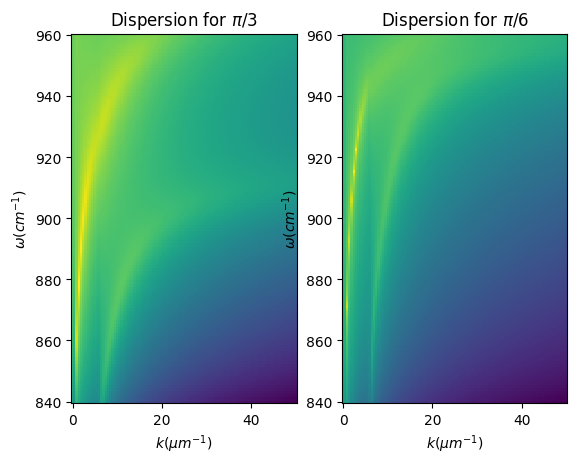

In [20]:
plt.subplot(1, 2, 1)
plt.pcolor(kx,w,-np.log(np.abs(Z[:,:,0])))
plt.xlabel("$k (\mu m^{-1})$")
plt.ylabel("$\omega (cm^{-1})$")
plt.title('Dispersion for $\pi/3$')

plt.subplot(1, 2, 2)
plt.pcolor(kx,w,-np.log(np.abs(Z[:,:,1])))
plt.xlabel("$k (\mu m^{-1})$")
plt.ylabel("$\omega (cm^{-1})$")
plt.title('Dispersion for $\pi/6$')